**M909 : Deep Learning for NLP |
Winter Semester 2023/24 |
Student ID: lt12200010 |
Student Name: Kleopatra Karapanagiotou**

**Assignment 1 : Code and Report**

#Word2Vec


In this notebook we will use of the Word2Vec package from the [Gensim library](https://radimrehurek.com/gensim/index.html) for producing Word2Vec embeddings on a dataset of Greek news aticles. The source of the dataset can be found on Kaggle [News Articles in Greek](https://www.kaggle.com/datasets/kpittos/news-articles). We will explore several parameters on our Word2Vec model.

# A few notes about the dataset.
It is in csv form and contains around 72k news headlines and text from the year 2012 to 2022 obtained from tvxs.gr.
Inspired by the Kaggle Notebook ["Topic Modeling in Greek News using ML techniques"](https://www.kaggle.com/code/andreasmarinis/topic-modeling-in-greek-news-using-ml-techniques), it will be interesting to explore word similarities and encyclopedia relation extraction from terms in the various topics of the dataset: Politics, International, Society, Culture, Natural Disasters, Health, Economy.
So let's get into it!




#Preparation

The text column of our dataset contains entire articles, meaning that each row contains a series of multiple sentences. Since we want our Word2Vec model to learn distributed representations of **words** on the sentence level and capture semantic meaning, we wil have to start with the following preprocessing steps:

1. Remove NaNs, Duplicate rows
2. Lowercasing and stress normalisation (both modern and ancient Greek stressing removed)
3. Punctuation and Special character removal
4. link- and url removal through html parsing
5. Usernames, email addresses
6. Greek alphanumerics (1ος, 2ος, 16χρονος..)
7. Sentence tokenisation (full-stop based) and word tokenisation for every sentence.
8. Removal of left punctuation (full-stop charater) and numerics.
9. Stopword removal, from a list of crawled Greek stopwords
10. Removal of sentences will Latin characters (threshold of 0.8 for list items with latin characters for a sentence-- remove sentences with more than 80% latin strings)
11. Corpus analysis on the distribution of sentence length to decide the lower and upper boundaries for sentence length in the corpus
12. Concatenation of all the lists of tokenized words into one large list

**Final output:** A list containing a sequence of lists, ready to be the input for the Word2Vecmodel.

In [1]:

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install beautifulsoup4

In [1]:
# Import necessary libraries
import re
import pandas as pd
import gensim
from gensim.models import Word2Vec
import random
import nltk
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models.phrases import Phrases, Phraser
import string
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
#Function to clean the dataframe from duplicate rows, and NaN values
def clean_dataframe(dataframe):
    # Print the shape before cleaning
    print('\nData shape before cleaning:')
    print(dataframe.shape)

    # Remove duplicate rows, keeping the first occurrence
    dataframe.drop_duplicates(keep='first', inplace=True)
    print('\nData shape after removing duplicate rows:')
    print(dataframe.shape)

    # Remove rows with NaN values
    dataframe.dropna(inplace=True)
    print('\nData shape after removing rows with NaN values:')
    print(dataframe.shape)

    return dataframe

def replaceMultiple(main, replacements, new):
  for elem in replacements:
    if elem in main:
      main = main.replace(elem, new)
  return main

def normalize(x):
  x = replaceMultiple(x, ['ά', 'ὰ', 'ἀ','ἁ','ἂ','ἃ','ἄ','ἅ','ἆ','ἇ','ᾰ','ᾱ','ᾲ','ᾳ','ᾴ','ᾶ','ᾷ'], 'α')
  x = replaceMultiple(x, ['έ','ὲ','ἐ','ἑ','ἒ','ἓ','ἔ','ἕ'], 'ε')
  x = replaceMultiple(x, ['ή','ὴ','ἠ','ἡ','ἢ','ἣ','ἤ','ἥ','ἦ','ἧ','ῂ','ῃ','ῄ','ῆ','ῇ'], 'η')
  x = replaceMultiple(x, ['ί','ὶ','ἰ','ἱ','ἲ','ἳ','ἴ','ἵ','ἶ','ἷ','ῐ','ῑ','ῒ','ΐ','ῖ','ῗ'], 'ι')
  x = replaceMultiple(x, ['ὸ','ό','ὀ','ὁ','ὂ','ὃ','ὄ','ὅ'], 'ο')
  x = replaceMultiple(x, ['ύ','ὺ','ΰ', 'ϋ','ὐ','ὑ','ὒ','ὓ','ὔ','ὕ','ὖ','ὗ','ῠ','ῡ','ῢ','ΰ','ῦ'], 'υ')
  x = replaceMultiple(x, ['ώ','ὼ','ῶ','ῲ','ῳ','ῴ','ῶ','ῷ','ὠ','ὡ','ὢ','ὣ','ὤ','ὥ','ὦ','ὧ'], 'ω')
  return x

def preprocess_text(text, stopwords_file,min_length=7, max_length=20):
  # Load stopwords from file
    with open(stopwords_file, 'r', encoding='utf-8') as file:
        stopwords = set(file.read().splitlines())
    # Lowercasing
    text = text.lower()
    text=normalize(text)
    # Define the list of punctuation to remove
    puncts = [',', '...', '"', '«', "»", ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>',
              '%', '=', '#', '*', '+', '\\', '•', '~', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→',
              '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”', '–', '●',
              'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹',
              '─', '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
              'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・',
              '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']

    # Removal of special characters and punctuation
    for punct in puncts:
        text = text.replace(punct, '')

    # Removal of HTML/HTTPS/URLs
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    # Remove usernames @
    text = re.sub(r'@[^\s]+', '', text)
    # Removal of email addresses
    text = re.sub(r'\S+@\S+', '', text)
    # Remove Greek alphanumerics
    text = re.sub(r'\b\d+[α-ωΑ-Ω]+\w*\b', '', text)
    # Tokenization into sentences
    sentences = sent_tokenize(text)
    # Tokenization of words in each sentence
    tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]
    # Remove punctuation-only and numeric-only list items
    tokenized_sentences = [[word for word in sentence if word.isalpha()] for sentence in tokenized_sentences]
    # Remove stopwords
    tokenized_sentences = [
        [word for word in sentence if word.isalpha() and word.lower() not in stopwords]
        for sentence in tokenized_sentences]
    # Remove lists with more than 80% English words
    tokenized_sentences = [sentence for sentence in tokenized_sentences if
                           len(sentence) > 0 and (sum(word.isascii() for word in sentence) / len(sentence)) <= 0.8]
    # Remove sentences with length less than min_length or greater than max_length
    tokenized_sentences = [sentence for sentence in tokenized_sentences if min_length <= len(sentence) <= max_length]


    return tokenized_sentences



Applications

In [8]:
df=pd.read_excel('/content/drive/MyDrive/DL_NLP/Word2Vec/Assignment_1_Karapanagiotou/news_articles_greek.xlsx')
df=df['text']
df=clean_dataframe(df)
df=df.apply(preprocess_text,stopwords_file='/content/drive/MyDrive/DL_NLP/Word2Vec/Assignment_1_Karapanagiotou/Greek-Stopwords (1).txt')
# Concatenate all the lists of tokenized words into one large list
all_tokenized_sentences = [sentence for sublist in df for sentence in sublist]
len(all_tokenized_sentences)


Data shape before cleaning:
(72105,)

Data shape after removing duplicate rows:
(72026,)

Data shape after removing rows with NaN values:
(72026,)


755099

Our corpus contains **755099** lists of tokenized sentences

#Corpus Analysis
We now ready to perform some quantitative analysis for removing outlier sentences from our corpus

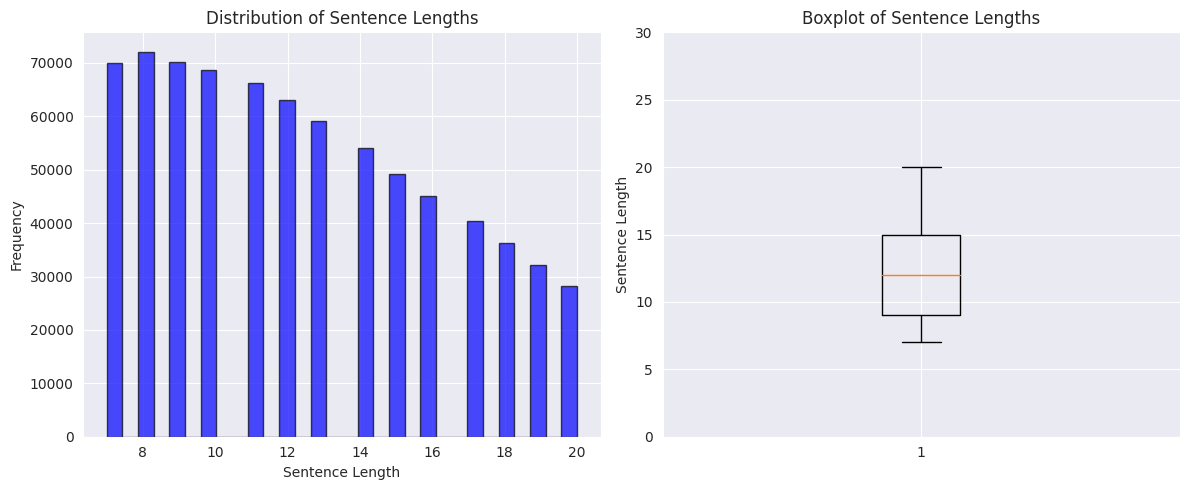

In [9]:
# Calculate sentence lengths
sentence_lengths = [len(sentence) for sentence in all_tokenized_sentences]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Plot the histogram
axs[0].hist(sentence_lengths, bins=30, color='blue', edgecolor='black', alpha=0.7)
axs[0].set_title('Distribution of Sentence Lengths')
axs[0].set_xlabel('Sentence Length')
axs[0].set_ylabel('Frequency')
# Plot the boxplot with adjusted y-axis limits for zooming in
axs[1].boxplot(sentence_lengths)
axs[1].set_title('Boxplot of Sentence Lengths')
axs[1].set_ylabel('Sentence Length')

# Adjust y-axis limits for the boxplot
axs[1].set_ylim(0, max(sentence_lengths) + 10)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

This is the distribution of sentence lengths after removing outliers. Outlier values were only reported on the upper boundary only. So we wee that more than 50 % of the sentences have a sentence length between 7 and 15 tokens , after stoword removal. This means that our window size cannot exceed the 10 tokens per each side. We will experiment with smaller window size values.

In [10]:
from scipy.stats import skew
skewness = skew(sentence_lengths)
print("Skewness:", skewness)

Skewness: 0.32873334451587416


 Our data are moderately skewed, which is an expected behaviour for sentences in journalistic articles.

In [11]:
mean_sentence_length = sum(sentence_lengths) / len(sentence_lengths)

print("Mean Sentence Length:", mean_sentence_length)

Mean Sentence Length: 12.416945327698752


#Corpus lemmatisation


Corpus lemmatization was a step that was tried but skipped, due to the inaccurate lemmatisation results of the Greek spacy. Furthermore, in our notebook we try to capture similarities between bigram named entities like "κυριακος_μητσοτακης" -"αλεξης_τσιπρας", but after the lemmatisation process, those entities were not recognized in the corpus.

In [ ]:
#def lemmatize_corpus(corpus):
    # Load the spaCy language model
#    nlp = spacy.load("el_core_news_sm")

    # Initialize a list to store the lemmatized corpus
#    lemmatized_corpus = []

    # Iterate through each list of tokenized texts in the corpus
#    for text_list in corpus:
        # Join the tokens in the list to create a single string
#        text_str = ' '.join(text_list)

        # Process the text with spaCy
#        doc = nlp(text_str)

        # Initialize a list to store lemmatized tokens for the current text
#        lemmas = []

        # Iterate through the tokens in the processed text and append their lemmas to the list
#        for token in doc:
#            lemmas.append(token.lemma_)

        # Append the list of lemmatized tokens to the lemmatized_corpus
 #       lemmatized_corpus.append(lemmas)

 #   return lemmatized_corpus



#final_corpus = lemmatize_corpus(all_tokenized_sentences)
#print(final_corpus[1])
#len(final_corpus)

In [ ]:
#corvert corpus into a dataframe and save int .csv to avoid reusing spacy lemmatization process

#df = pd.DataFrame({'Text': final_corpus})
#df.to_csv('corpus.csv', index=False)

#Bigrams:
We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences. https://radimrehurek.com/gensim/models/phrases.html

The main reason we do this is to catch Named entities like "κυριακος_μητσοτακης" or "αλεξης_τσιπρας" and limti the corpus's vocabulary size

In [12]:
phrases = Phrases(all_tokenized_sentences, min_count=10, progress_per=10000)  #Phrases() takes a list of list of words as input and creates the relevant phrases from the list of sentences
bigram = Phraser(phrases)
sentences = bigram[all_tokenized_sentences]   #Transform the corpus based on the bigrams detected


#Train a Word2Vec model (gensim implementation)

With our preprocessing, we are now ready to start training our Word2Vec model. Let's keep in mind that this dataset contains around 72k articles of a Greek news website, where each article belongs to a different topic and in each article different incidents and different named entities are mentioned.
With this dataset we can give our Word2Vec model development 2 directions:

A. Named entity recognition: We look for similar words which are **interchangeable**, i.e. one word can substitute another in the similar context. (like names of countries, political parties, sport teams etc., e.g. Mitsotakis-Tsipras, ARIS-PAOK)

B. Topic extraction: word similarity equals **topical relation** between two words. These words talk about the same topic or are terms of the same domain.(like events and their participants or their cause, an illness and its medicine, entities and their role e.g Mitsotakis- νεα δημοκρατια, covid-vaccine)

Based on our min and max sentence length and the recommendations of [Lev Konstantinovskiy(2017)](https://www.youtube.com/watch?v=tAxrlAVw-Tk&t=648s):
- For the first direction (interchangeable) we will train Word2Vec with **skipgram** and experiment with **small window sizes** (2 and 5).
- For the second direction (topical relation) we will run W2V with **skipgram** again and experiment with ** a bigger window size** (8).


**WORD2VEC MODELs**

**Set model parameters**

In [13]:
model1 =Word2Vec(sg = 1,min_count=5,window=2,vector_size=100, alpha=0.1, hs=0,negative=5,workers=3,sample=0.1)
model2=Word2Vec(sg = 1,min_count=5,window=5,vector_size=100, alpha=0.1,hs=0,negative=5,workers=3,sample= 0.1)
model3=Word2Vec(sg = 1,min_count=5,window=8,vector_size=100, alpha=0.1,hs=0,negative=5,workers=3,sample= 0)


# Size of dimensionality of word vectors: 100
# Window, the maximum distance between the target word and its neighboring word :2/5/8
# Minimum count, ignoring all words with total frequency lower than this, words must appear this many times to be in vocab: 5
# Sg, training algorithm: Skip-Gram
# The number of worker threads used to train the model: 3
# 0: Negative sampling
# Number of negative samples: 5
#alpha: the learing rate
#sample :Words that are more frequent than this threshold will be randomly downsampled.The smaller the sample the more aggressive the downsampling useful range is (0, 1e-5)

**Build the vocab**



In [14]:
from time import time
t = time()
model1.build_vocab(sentences )
model2.build_vocab(sentences )
model3.build_vocab(sentences )


print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.87 mins


**Train the Word2Vec model**

In [15]:
model1.train(sentences, total_examples=len(sentences), epochs=10)
model2.train(sentences , total_examples=len(sentences), epochs=10)
model3.train(sentences , total_examples=len(sentences), epochs=10)


(79737380, 82913990)

In [16]:
# Access the word vectors
############################################################################################
models = [model1, model2, model3]

for idx, model in enumerate(models, start=1):
    print(f"Accessing word vectors for model{idx}:")
    word_vectors = model.wv
    print('The vocabulary includes {} unique words.'.format(len(word_vectors.key_to_index)))

    # Access the word vector for a specific word (e.g., 'συριζα')
    word = 'συριζα'
    if word in word_vectors:
        vector = word_vectors[word]
        print(f'The length of the word vector for "{word}":', len(vector))
        print(f'Numpy vector of the word "{word}":\n', vector)
    else:
        print(f'The word "{word}" is not in the vocabulary of model{idx}.\n')

    print('\n')

Accessing word vectors for model1:
The vocabulary includes 126298 unique words.
The length of the word vector for "συριζα": 100
Numpy vector of the word "συριζα":
 [ 0.17366193 -0.03214309 -0.13077275  0.20077015 -0.14254698 -0.12942344
  0.39593163 -0.11420102 -0.1873117  -0.5829744   0.23360558 -0.73815954
 -0.40248132 -0.3628786  -0.40283564 -0.38855067  0.23514554 -0.06594463
 -0.14734583 -0.458289    0.04377849  0.65312684 -0.02027591 -0.01557787
  0.09225133 -0.2513552  -0.38776946 -0.03537207 -0.40884674 -0.26646847
  0.18642575  0.27552956 -0.17687961 -0.60617995  0.0108176  -0.3630864
  0.7999938  -0.46470279  0.20259935  0.26120633  0.03387893  0.50368524
 -0.00822095 -0.29190952  0.38410416  0.09891783 -0.53562564  0.39920938
  0.42076787  0.39499846 -0.11455019 -0.31675938  0.0605185  -0.05237727
 -0.20784308 -0.05130203  0.31436935 -0.43071917  0.06741287  0.26339087
  0.47459465 -0.5356562  -0.12148676 -0.55819374 -0.36246163  0.25523603
  0.04197605 -0.6163737   0.039231

#Model Exploration

In [17]:
def get_random_words(model):
    vocab = list(model.wv.index_to_key)
    random_words = [(random.choice(vocab), random.choice(vocab)) for _ in range(10)]
    return random_words, vocab

def check_vocab(model_vocabs, try_words):
    print("%30s    %s" % ('Word', 'Included'))
    print("%30s    %s" % ('====', '========'))

    for model_name, vocab in model_vocabs.items():
        print(f"Checking vocabulary for {model_name}:")
        for word in try_words:
            print("%30s    %s" % (word, str(word in vocab)))
            # If the word isn't already lower case, try lower case as well.
            if not word.lower() == word:
                print("%30s    %s" % (word.lower(), str(word.lower() in vocab)))
        print("\n")

# Initialize a dictionary to store vocabularies for each model
model_vocabs = {}

# Print 20 random words and populate model_vocabs
for idx, model in enumerate(models, start=1):
    print(f"Random words from model{idx}:")
    random_words, vocab = get_random_words(model)

    for word_pair in random_words:
        print('%30s %30s' % word_pair)

    model_vocabs[f"model{idx}"] = vocab


# List of words to check
try_words = ['κυριακος_μητσοτακης',
                    'νεα_δημοκρατια',
                    'αλεξης_τσιπρας',
                    'υπουργειο_εξωτερικων',
                    'υπουργειο_οικονομικων',
                    'γιωργος_σεφερης',
                    'τζο_μπαιντεν',
                    'υποκειμενο_νοσημα',
                    'διασωληνωμενοι_ασθενεις']

# Call the check_vocab function with the model vocabularies and try_words
check_vocab(model_vocabs, try_words)



Random words from model1:
                  τοξικο_κλιμα                        αλατιου
                        σαγκαη                     απεπλευσαν
               μελων_επιτροπης                       μεριμνας
                       μπασμπι                   ηλικιας_ετων
                διαχειριστικης                      αγγλικους
                      θυμωμενο                     λειτουργια
                        εσπασα               συνολικη_αποδοση
                  δολοφονημενα                   ιβαν_σαββιδη
      επιστημονικης_κοινοτητας               μυστικη_υπηρεσια
                      αρσενιου                      συντροφοι
Random words from model2:
                        mosaic         φαρμακευτικος_συλλογος
                 απροετοιμαστη                       κορινθος
       περιστατικα_αστυνομικης                  κρυπτονομισμα
                           εντ                   βραδυ_τριτης
                 νεων_φαρμακων             αγνωστη_κατευθυνση
                  

**Find the most similar named_entities**

In [18]:
named_entities = ['ελλαδα', 'κυριακος_μητσοτακης', 'ολυμπιακος']

for idx, model in enumerate(models, start=1):
    print(f'Most similar words for named entities in model{idx}:\n')
    for entity in named_entities:
        similar_words = model.wv.most_similar(entity)
        print(f'Most similar words for "{entity}":\n', similar_words)
        print('\n')

Most similar words for named entities in model1:

Most similar words for "ελλαδα":
 [('χωρα', 0.8036606311798096), ('ευρωπη', 0.7219130396842957), ('ουραγους', 0.6944064497947693), ('ιταλια', 0.652439534664154), ('τουρκια', 0.6506747603416443), ('χειροτερη_θεση', 0.6380224227905273), ('ευρωπαϊκη_χωρα', 0.6375015377998352), ('σλοβακια_σλοβενια', 0.6209450960159302), ('πορτογαλια_ισπανια', 0.6208418607711792), ('θλιβερη_πρωτια', 0.6205682158470154)]


Most similar words for "κυριακος_μητσοτακης":
 [('μητσοτακης', 0.8690891861915588), ('αλεξης_τσιπρας', 0.8272742033004761), ('πρωθυπουργος', 0.8200730681419373), ('τσιπρας', 0.8038445711135864), ('προεδρος_νδ', 0.7942981719970703), ('πρωθυπουργος_κυριακος', 0.7594904899597168), ('προεδρος_συριζα', 0.7515526413917542), ('ιδιος_κυριακος', 0.7166814804077148), ('απευθυνομενος_κυριακο', 0.715607762336731), ('μητσοτακης_διαγγελμα', 0.7010779976844788)]


Most similar words for "ολυμπιακος":
 [('παοκ', 0.8500607013702393), ('παναθηναϊκος', 0.8368

In the "most similar to" test, we can make the following observations from our models:

**Model 1:** It seems that the first model captured the semantic similarities very well. Almost all similar words of all 3 terms are of the same semantic category.
For the country "ελλαδα" most of the similar words were also countries.
For "κυριακος_μητσοτακης": Most terms were either other named entities with the same property (prim minister, like "αλεξης_τσιπρας", or they are coreferential terms for the entity, like "προεδρος_κυριακος", "ίδιος_πρωθυπουργός".
For "ολυμπιακος":all similar words were other sport teams.


**Model 2:** We observe quite different results for the 1st term "ελλάδα". Apart from the two first similar terms which are common for all 3 models, the remaining words are topically related to the word 'ελλαδα', like: "θανατους_εκατομυριο", "ανερχονται_σημερινα", "χειροτερη θέση", "ακριβοτερη_χωρα". This is probably referring to the covid mortality report for Greece. For the rest 2 tested terms, the results were similar to the first model.

**Model 3**: The results were quite similar to those of model 2.

**Compute similarity between named entities who belong to different topics**

In [19]:
entity_pairs = [
    ('κυριακος_μητσοτακης', 'γιωργος_σεφερης'),
    ('ολυμπιακος', 'κορονοιος'),
    ('ουκρανια', 'ισπανια')
]

for idx, model in enumerate(models, start=1):
    print(f'Similarity between named entity pairs in model{idx}:\n')
    for entity_pair in entity_pairs:
        similarity_score = model.wv.n_similarity([entity_pair[0]], [entity_pair[1]])
        print(f'Cosine similarity between "{entity_pair[0]}" and "{entity_pair[1]}" is:', similarity_score)
    print('\n')

Similarity between named entity pairs in model1:

Cosine similarity between "κυριακος_μητσοτακης" and "γιωργος_σεφερης" is: 0.15008542
Cosine similarity between "ολυμπιακος" and "κορονοιος" is: 0.0
Cosine similarity between "ουκρανια" and "ισπανια" is: 0.38975897


Similarity between named entity pairs in model2:

Cosine similarity between "κυριακος_μητσοτακης" and "γιωργος_σεφερης" is: 0.15068278
Cosine similarity between "ολυμπιακος" and "κορονοιος" is: 0.0
Cosine similarity between "ουκρανια" and "ισπανια" is: 0.29676044


Similarity between named entity pairs in model3:

Cosine similarity between "κυριακος_μητσοτακης" and "γιωργος_σεφερης" is: 0.13648142
Cosine similarity between "ολυμπιακος" and "κορονοιος" is: 0.0
Cosine similarity between "ουκρανια" and "ισπανια" is: 0.22373444




Similariy between to words: With this test we wanted to test the similarity between two terms that are semantically related, but topically unrelated. The have the same Part of speech but are not probable to co-occur in the same text.


For the first two tested pairs it seems that all models did very well in capturing the non relatedness of the terms. The interesting is the last pair, in which the 1st model gave around double higher score, meaning that the low window size help the model understand that these two words are similar because they are both countries.
Model 3 seems to be more efficient for capturing topical relations between words and it seems to understand that the two countries are less likely to have co-occured in the same context.

**Odd-one out**

In [20]:
triples_list = [
    ('παοκ', 'ολυμπιακος', 'καραισκακη'),
    ('κυριακος_μητσοτακης', 'αλεξης_τσιπρας', 'νεα_δημοκρατια')
]

for idx, model in enumerate(models, start=1):
    print(f'Word that does not match with the rest in model{idx}:\n')
    for triple in triples_list:
        not_matching_word = model.wv.doesnt_match(list(triple))
        print(f'Word that does not match in {triple}: {not_matching_word}')
    print('\n')

Word that does not match with the rest in model1:

Word that does not match in ('παοκ', 'ολυμπιακος', 'καραισκακη'): ολυμπιακος
Word that does not match in ('κυριακος_μητσοτακης', 'αλεξης_τσιπρας', 'νεα_δημοκρατια'): νεα_δημοκρατια


Word that does not match with the rest in model2:

Word that does not match in ('παοκ', 'ολυμπιακος', 'καραισκακη'): ολυμπιακος
Word that does not match in ('κυριακος_μητσοτακης', 'αλεξης_τσιπρας', 'νεα_δημοκρατια'): νεα_δημοκρατια


Word that does not match with the rest in model3:

Word that does not match in ('παοκ', 'ολυμπιακος', 'καραισκακη'): παοκ
Word that does not match in ('κυριακος_μητσοτακης', 'αλεξης_τσιπρας', 'νεα_δημοκρατια'): νεα_δημοκρατια




Even though the model did not catch the vector for the word "καραισκακη", it seems that in the last model, it managed to give less probability to "παοκ" and capture the similarity between "καραισκακη and ολυμπιακος". For the second pair, it can be infered that there is a strong cooccurence of the named entity "αλεξης_τσιπρας" Next to "κυριακος_μητσοτακης", so that no other topical related term can be easily dropped out. Also "αλεξης_τσιπρας" Is both a named entity and a topically related term, which implies that maybe our **model** 3 is capturing both the semantic and the topical relation.

**Analogy difference**

In [21]:
# For model1, model2, model3
models_1 = [model1, model2, model3]

analogy_difference_1 = ["ολυμπιακος", "μητσοτακης", "τσιπρας"]
for idx, model in enumerate(models_1, start=1):
    print(f'Analogy difference for model{idx}:\n')
    analogy_result = model.wv.most_similar(positive=[analogy_difference_1[0], analogy_difference_1[1]],
                                           negative=[analogy_difference_1[2]], topn=3)
    print(f'Most similar words based on analogy difference: {analogy_result}\n')

Analogy difference for model1:

Most similar words based on analogy difference: [('αεκ', 0.7181831002235413), ('παοκ', 0.7127392292022705), ('αελ', 0.6921119689941406)]

Analogy difference for model2:

Most similar words based on analogy difference: [('ματς', 0.7287254333496094), ('παναθηναϊκος', 0.7239900231361389), ('αεκ', 0.7216362953186035)]

Analogy difference for model3:

Most similar words based on analogy difference: [('παναθηναϊκος', 0.7370814681053162), ('μακαμπι', 0.7092284560203552), ('αεκ', 0.7079706788063049)]



Considering our encyclopedic knowledge of Greek sports teams, we can say that model 1 and 3 captured teams that are connected the same way that the named entities "μητσοτακης" and "τσιπρας" are connected. Again, **model** 3 is the one that managed to capture the deeper connection between the two temas which is the same connection between the two named entities. Both pairs are also opponents in Greece, the first pair in the polilical field the other pair in the sport field.

#t-SNE visualisations
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.
We will plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot interesting patterns.

To make the visualizations more relevant, we will look at the relationships between a query word (in **red**), its most similar words in the model (in **blue**), and other words from the vocabulary (in **green**).

In [33]:
def tsnescatterplot(model, word, list_names, title=''):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title(f't-SNE visualization for {word.title()} - {title}')
    plt.show()

**10 Most similar words vs. 8 Random words**
Let's compare where the vector representation of the country Greece (Ελλαδα), its 10 most similar words from each of the 2 chosen models, as well as 8 words with different syntactic role (e.g. verbs) and 8 words from a different domain field (e.g. sports)

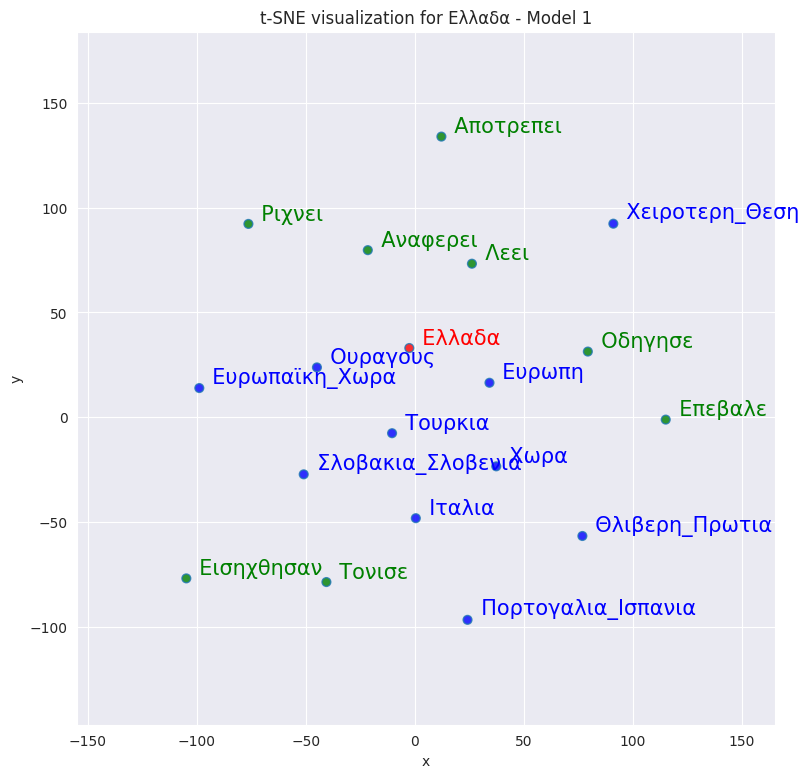

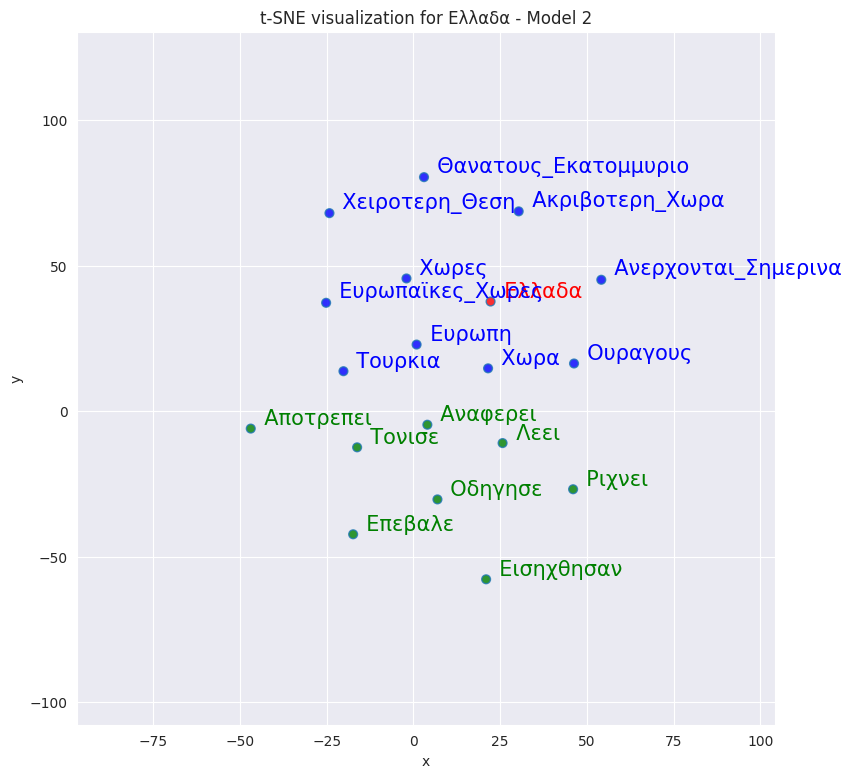

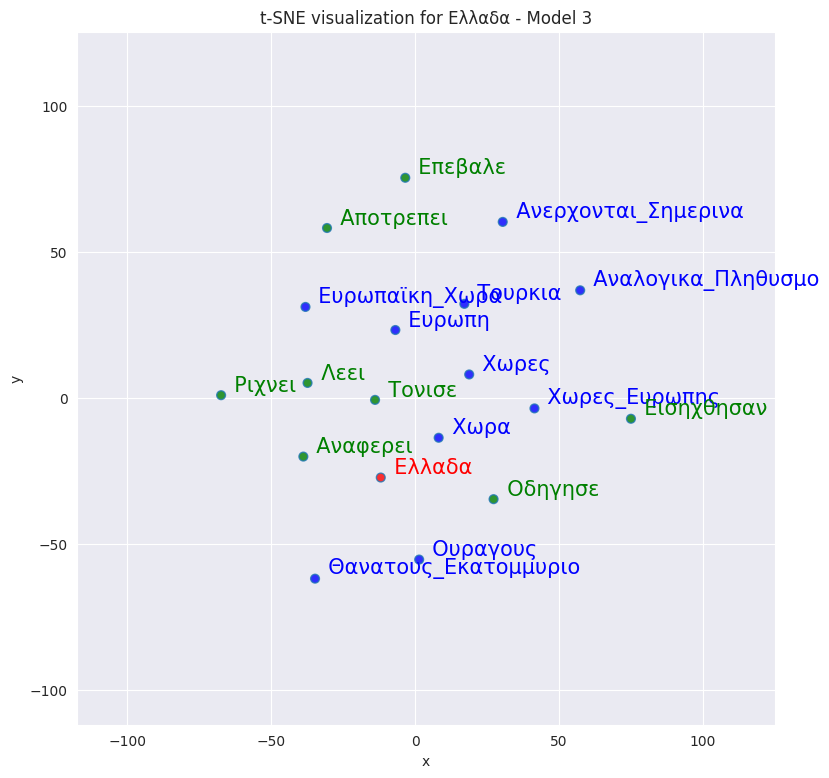

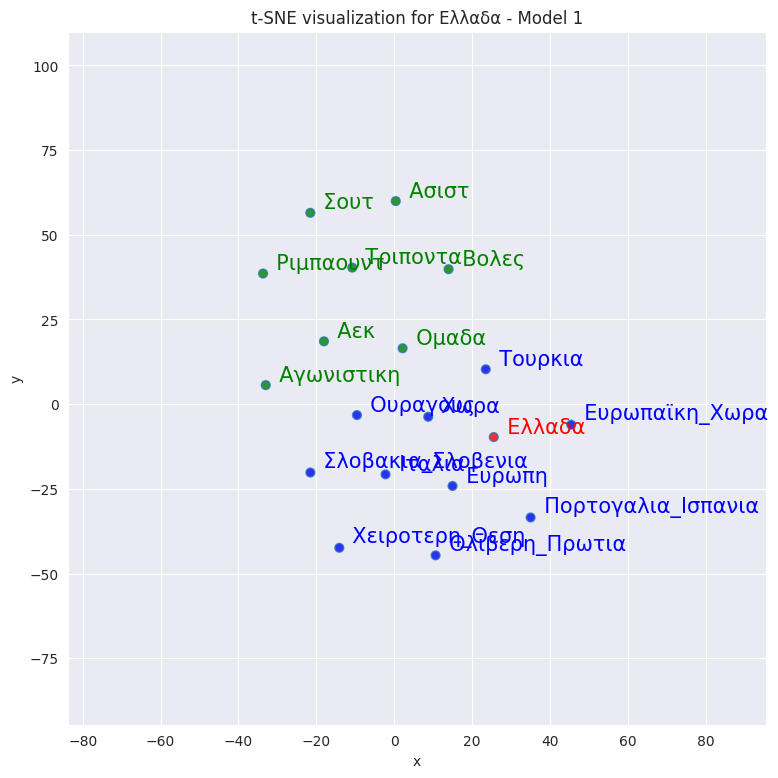

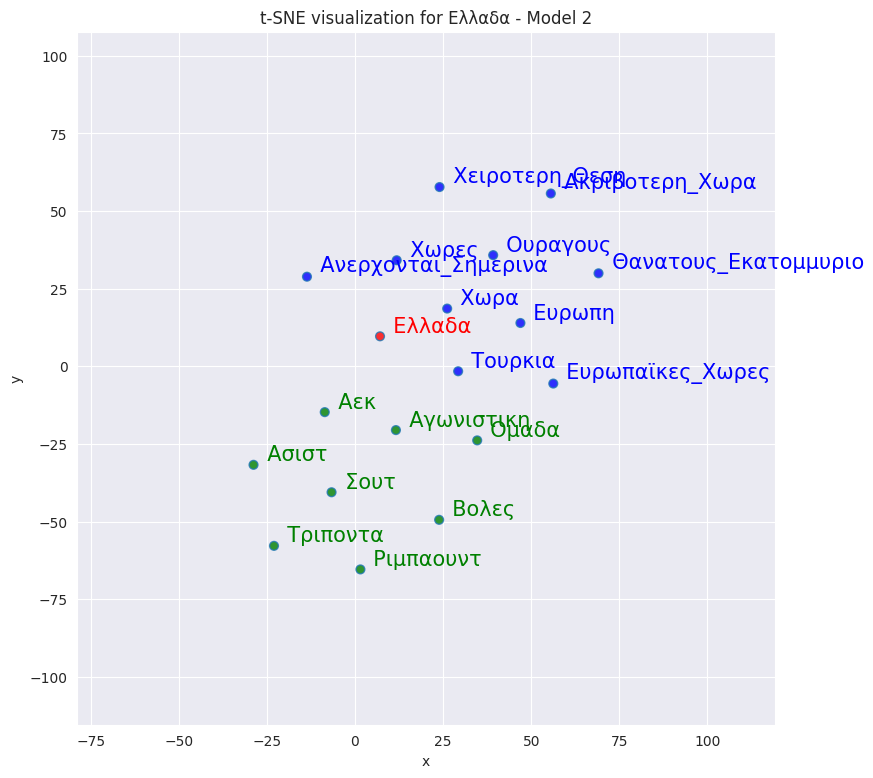

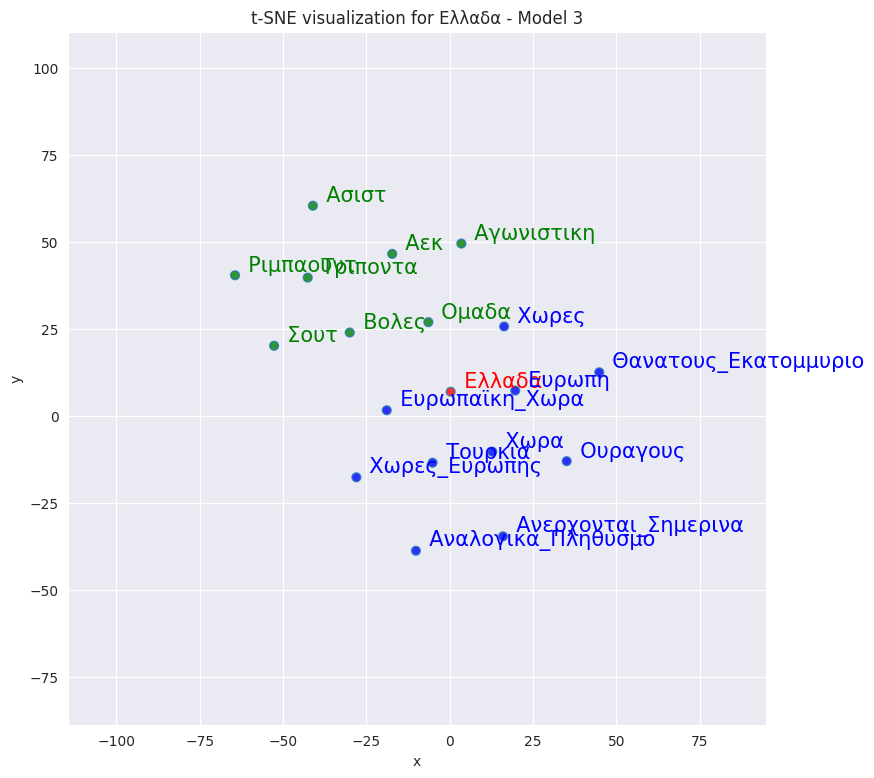

In [34]:
tsnescatterplot(model1, 'ελλαδα', ['ριχνει', 'λεει', 'αναφερει', 'τονισε', 'εισηχθησαν', 'επεβαλε', 'αποτρεπει', 'οδηγησε'], title='Model 1')
tsnescatterplot(model2, 'ελλαδα', ['ριχνει', 'λεει', 'αναφερει', 'τονισε', 'εισηχθησαν', 'επεβαλε', 'αποτρεπει', 'οδηγησε'], title='Model 2')
tsnescatterplot(model3, 'ελλαδα', ['ριχνει', 'λεει', 'αναφερει', 'τονισε', 'εισηχθησαν', 'επεβαλε', 'αποτρεπει', 'οδηγησε'], title='Model 3')

tsnescatterplot(model1, 'ελλαδα', ['ριμπαουντ', 'τριποντα', 'ασιστ', 'αγωνιστικη', 'βολες', 'ομαδα', 'σουτ', 'αεκ'], title='Model 1')
tsnescatterplot(model2, 'ελλαδα', ['ριμπαουντ', 'τριποντα', 'ασιστ', 'αγωνιστικη', 'βολες', 'ομαδα', 'σουτ', 'αεκ'], title='Model 2')
tsnescatterplot(model3, 'ελλαδα', ['ριμπαουντ', 'τριποντα', 'ασιστ', 'αγωνιστικη', 'βολες', 'ομαδα', 'σουτ', 'αεκ'], title='Model 3')

For the first visualisations with 8 words from a different part of Speech it seems that:
- model 1 managed to create cluster around the 10 most common words and the remaining 8 random words of different part of speech were scattered around that cluster.
- model 3 did not create a clear cluster of the common words, and there is no clear differentiation between the verbs and the nouns (this is a good sign for model 3, because it is mainly meant for topical relation due to its bigger window size).
- model 2: was able to create the clearest clusterings not only for the query word and its common words, but also for the 8 verbs. It seems that model2 has developed very good embeddings for the part of speech of verbs.

For the second visualisations with 10 common words and 8 random words of a different domain, it seems that:
- In model 1 the words from the different domain are far but not very far from the common words for "ελλαδα"
- In models 2 and 3 there is a clear clustering around the 8 domain specific words and the 10 common words for "ελλαδα" and the two clusters have a bigger gap between them.

#Comments/ Overall Thoughts

After a lot of experimentation in preprocessing it seems that all our 3 models gave meaningful results, and all three models can be further optimised.
- Model 1: The small window size (2) helped to capture the similarity between words of the same semantic category or POS tag pretty well. It could be otpimised for tasks that require Named Entity Recognition.
- Model 2: The bigger window size (5) seems to have helped capturing semantic similarity between words of the same POS tag and also showed some signs for capturing topical relation between words. This model could be optimised for POS tagging.
- Model 3: The bigger window size and the more aggressive subsampling of highly frequent words helped to capture similarity between words belonging to the same topic and thus this model could be optimised for tasks that require topic modelling or topic extraction.

Some optimisation steps we could try in each of the 3 models:
1. Increase vector dimensionality to 300
2. in negative sampling, increase the number of negative samples
3. Adjust the learning rate by adding a min_alpha value to the training process
4. Increase the min count to exclude more infrequent words.

In our experiments we chose to work with the Skipgram algorithm and Negative sampling as it is considered a good baseline for capturing semantic similarities.
Since Greek is a morphologically rich language we could also try CBOW algorithm in order to capture syntactic relationships between words and get vectors that capture the morphological variations of each word.
Also another task for further experimentation is to apply Doc2Vec and try to capture semantic similarities between the articles of this dataset.






#References

- [GENSIM models.word2vec – Word2vec embeddings](https://radimrehurek.com/gensim/models/word2vec.html)
- [Gensim Word2Vec Tutorial](https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial)

- [Deep Learning for NLP: Word2Vec, Doc2Vec, and Top2Vec Demystified](https://medium.com/mlearning-ai/deep-learning-for-nlp-word2vec-doc2vec-and-top2vec-demystified-3842b4fad5c9)

- [Text Preprocessing in Python: Steps, Tools, and Examples](https://medium.com/product-ai/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908)

- [Topic Modeling in Greek News using ML techniques](https://www.kaggle.com/code/andreasmarinis/topic-modeling-in-greek-news-using-ml-techniques)

- [Optimize Computational Efficiency of Skip-Gram with Negative Sampling](https://aegis4048.github.io/optimize_computational_efficiency_of_skip-gram_with_negative_sampling)

- [Vector Semantics and
Embeddings](https://web.stanford.edu/~jurafsky/slp3/6.pdf)

- [A Beginner’s Guide to Word Embedding with Gensim Word2Vec Model](https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92)